# Getting started

### Initialize streams

[Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects define material flow rates along with its thermodynamic state. Before creating streams, a [Thermo](https://thermosteam.readthedocs.io/en/latest/Thermo.html) property package must be defined. Alternatively, we can just pass chemical names and BioSTEAM will automatically create a property package based on ideal mixing rules and UNIFAC activity coefficients for thermodynamic equilibrium. More complex packages can be defined through Thermosteam, BioSTEAM's premier thermodynamic engine. Please visit [Thermosteam's documentation](https://thermosteam.readthedocs.io/en/latest/index.html) for a complete tutorial on [Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects and how to create a property package. In this example, a simple feed stream with a few common chemicals will be initialized:

In [1]:
import biosteam as bst
bst.settings.set_thermo(['Water', 'Methanol'])
feed = bst.Stream(Water=50, Methanol=20)
feed.show()

Stream: s1
 phase: 'l', T: 298.15 K, P: 101325 Pa
 flow (kmol/hr): Water     50
                 Methanol  20


Set prices for performing techno-economic analysis later:

In [2]:
feed.price = 0.15 # USD/kg
feed.cost # USD/hr

231.24018

### Process settings

**Process settings include price of feeds and products, conditions of utilities, and the chemical engineering plant cost index. These should be set before simulating a system.**

Set the chemical engineering plant cost index:

In [3]:
bst.CE # Default year is 2017

567.5

In [4]:
bst.CE = 603.1 # To year 2018

Set [PowerUtility](../PowerUtility.txt) options:

In [5]:
bst.PowerUtility.price # Default price (USD/kJ)

0.0782

In [6]:
bst.PowerUtility.price = 0.065 # Adjust price

Set [HeatUtility](../HeatUtility.txt) options via [UtilityAgent](../UtilityAgent.txt) objects, which are [Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects with additional attributes to describe a utility agent:

In [7]:
bst.HeatUtility.cooling_agents # All available cooling agents

[<UtilityAgent: cooling_water>,
 <UtilityAgent: chilled_water>,
 <UtilityAgent: chilled_brine>]

In [8]:
cooling_water = bst.HeatUtility.get_cooling_agent('cooling_water')
cooling_water # A UtilityAgent

UtilityAgent: cooling_water
 heat_transfer_efficiency: 1.000
 heat_transfer_price: 0 USD/kJ
 regeneration_price: 0.000488 USD/kmol
 T_limit: 325 K
 phase: 'l'
 T: 305.37 K
 P: 101325 Pa
 flow (kmol/hr): Water  1


In [9]:
# Price of regenerating the utility in USD/kmol
cooling_water.regeneration_price

0.00048785

In [10]:
# Other utilities may be priced for amount of heat transfered in USD/kJ
chilled_water = bst.HeatUtility.get_cooling_agent('chilled_water')
chilled_water.heat_transfer_price

5e-06

In [11]:
cooling_water.T = 302 # Change the temperature of cooling water (K)

In [12]:
bst.HeatUtility.heating_agents # All available heating agents

[<UtilityAgent: low_pressure_steam>,
 <UtilityAgent: medium_pressure_steam>,
 <UtilityAgent: high_pressure_steam>]

In [13]:
lps = bst.HeatUtility.get_heating_agent('low_pressure_steam') # A UtilityAgent
lps # Note that because utility changes phase, T_limit is None

UtilityAgent: low_pressure_steam
 heat_transfer_efficiency: 0.950
 heat_transfer_price: 0 USD/kJ
 regeneration_price: 0.238 USD/kmol
 T_limit: None
 phase: 'g'
 T: 412.19 K
 P: 344738 Pa
 flow (kmol/hr): Water  1


In [14]:
lps.regeneration_price = 0.20 # Adjust price (USD/kmol)

### Find design requirements and cost with Unit objects

[Creating a Unit](./Creating_a_Unit.ipynb) can be flexible. But in summary, a [Unit](../Unit.txt) object is initialized with an ID, and unit-specific arguments. BioSTEAM includes [essential unit operations](../units/units.txt) with rigorous modeling and design algorithms. Here we create a [Flash](../units/Flash.txt) object as an example:

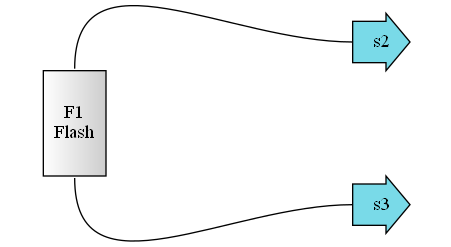

Flash: F1
ins...
[0] missing stream
outs...
[0] s2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [15]:
from biosteam import units

# Specify vapor fraction and isobaric conditions
F1 = units.Flash('F1', V=0.5, P=101325)
F1

Note that, by default, Missing Stream objects are given to inputs, `ins`, and empty streams to outputs, `outs`:

In [16]:
F1.ins

[<MissingStream>]

In [17]:
F1.outs

[<Stream: s2>, <Stream: s3>]

You can connect streams by setting the `ins` and `outs`:

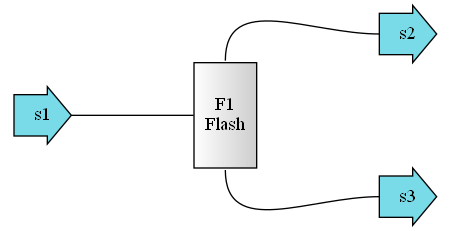

Flash: F1
ins...
[0] s1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     50
                    Methanol  20
outs...
[0] s2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [18]:
F1.ins[0] = feed
F1

To simulate the flash, use the `simulate` method:

In [19]:
F1.simulate()
F1.show()

Flash: F1
ins...
[0] s1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     50
                    Methanol  20
outs...
[0] s2
    phase: 'g', T: 359.63 K, P: 101325 Pa
    flow (kmol/hr): Water     19
                    Methanol  16
[1] s3
    phase: 'l', T: 359.63 K, P: 101325 Pa
    flow (kmol/hr): Water     31
                    Methanol  4


C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:79: CostWarning: <Flash: F1> Vertical vessel weight (399.5 lb) is out of bounds (4200 to 1e+06 lb).
  return method(pressure, diameter, length)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:79: CostWarning: <Flash: F1> Vertical vessel length (7.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)


Note that warnings notify you whether purchase cost correlations are out of range for the given design. This is ok for the example, but its important to make sure that the process is well designed and cost correlations are suitable for the domain.

The `results` method returns simulation results:

In [20]:
F1.results() # Default returns DataFrame object with units

Flash                                           Units            F1
Low pressure steam  Duty                        kJ/hr      1.76e+06
                    Flow                      kmol/hr          45.4
                    Cost                       USD/hr          9.07
Design              Vessel type                            Vertical
                    Length                         ft           7.5
                    Diameter                       ft           1.5
                    Weight                         lb           399
                    Wall thickness                 in          0.25
                    Vessel material                    Carbon steel
Purchase cost       Vertical pressure vessel      USD      1.16e+04
                    Heat exchanger                USD      5.12e+03
Total purchase cost                               USD      1.67e+04
Utility cost                                   USD/hr          9.07

In [21]:
F1.results(with_units=False) # Returns Series object without units

Low pressure steam   Duty                            1.76e+06
                     Flow                                45.4
                     Cost                                9.07
Design               Vessel type                     Vertical
                     Length                               7.5
                     Diameter                             1.5
                     Weight                               399
                     Wall thickness                      0.25
                     Vessel material             Carbon steel
Purchase cost        Heat exchanger                  5.12e+03
                     Vertical pressure vessel        1.16e+04
Total purchase cost                                  1.67e+04
Utility cost                                             9.07
Name: F1, dtype: object

### Solve recycle loops and process specifications with System objects

**Designing a chemical process is no easy task. A simple recycle process consisting of a flash with a partial liquid recycle is presented here.**

Create a [Mixer](../units/mixing.txt) object and a [Splitter](../units/splitting.txt) object:

In [22]:
M1 = units.Mixer('M1')
S1 = units.Splitter('S1', outs=('liquid_recycle', 'liquid_product'),
                    split=0.5) # Split to 0th output stream
F1.outs[0].ID = 'vapor_product'
F1.outs[1].ID = 'liquid'

You can [find unit operations and manage flowsheets](./Managing_flowsheets.ipynb) with the `main_flowsheet`:

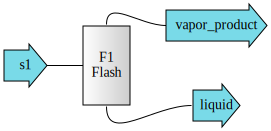

In [23]:
bst.main_flowsheet.diagram()

Connect streams and make a recycle loop using [-pipe- notation](./Using_-pipe-_notation.ipynb):

In [24]:
feed = bst.Stream('feed', Methanol=100, Water=450)

# Broken down -pipe- notation
[S1-0, feed]-M1     # M1.ins[:] = [S1.outs[0], feed]
M1-F1               # F1.ins[:] = M1.outs
F1-1-S1             # S1.ins[:] = [F1.outs[1]]

# All together
[S1-0, feed]-M1-F1-1-S1;

Now lets check the diagram again:

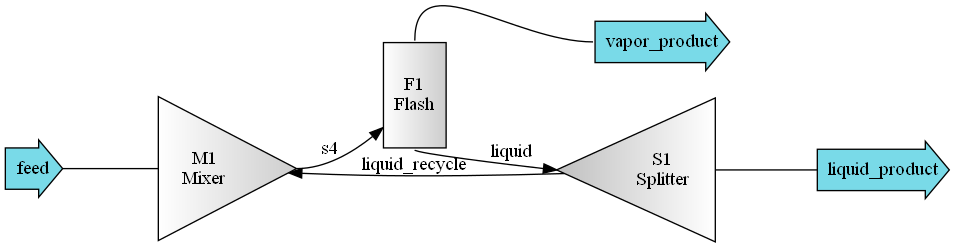

In [25]:
bst.main_flowsheet.diagram(format='png')

A [System](../System.txt) object can be created directly from the flowsheet:

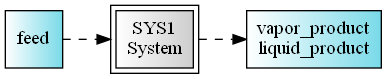

System: SYS1
 recycle: S1-0
 path: (M1, F1, S1)
 convergence error: Flow rate   0.00e+00 kmol/hr
                    Temperature 0.00e+00 K
 iterations: 0


In [26]:
SYS1 = bst.main_flowsheet.create_system('SYS1')
SYS1

Alternatively, create a [System](../System.txt) object by specifying an ID, a `recycle` stream and a `path` of units to run element by element:

In [27]:
sys1 = bst.System('sys1', path=(M1, F1, S1), recycle=S1-0) # recycle=S1.outs[0]
sys1.show() # Prints info without the diagram

System: sys1
 recycle: S1-0
 path: (M1, F1, S1)
 convergence error: Flow rate   0.00e+00 kmol/hr
                    Temperature 0.00e+00 K
 iterations: 0


Simulate the System object:

In [28]:
sys1.simulate()
sys1.show()

System: sys1
 recycle: S1-0
 path: (M1, F1, S1)
 convergence error: Flow rate   1.51e-01 kmol/hr
                    Temperature 4.43e-03 K
 iterations: 4


C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:79: CostWarning: <Flash: F1> Vertical vessel weight (2965 lb) is out of bounds (4200 to 1e+06 lb).
  return method(pressure, diameter, length)
C:\Users\yrc2\OneDrive\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:79: CostWarning: <Flash: F1> Vertical vessel length (10.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)


In [29]:
F1.show()

Flash: F1
ins...
[0] s4  from  Mixer-M1
    phase: 'l', T: 315.15 K, P: 101325 Pa
    flow (kmol/hr): Water     626
                    Methanol  108
outs...
[0] vapor_product
    phase: 'g', T: 366.37 K, P: 101325 Pa
    flow (kmol/hr): Water     275
                    Methanol  92.1
[1] liquid  to  Splitter-S1
    phase: 'l', T: 366.37 K, P: 101325 Pa
    flow (kmol/hr): Water     351
                    Methanol  15.8


In [30]:
F1.results()

Flash                                           Units            F1
Low pressure steam  Duty                        kJ/hr      1.82e+07
                    Flow                      kmol/hr           470
                    Cost                       USD/hr            94
Design              Vessel type                            Vertical
                    Length                         ft          10.5
                    Diameter                       ft           5.5
                    Weight                         lb      2.97e+03
                    Wall thickness                 in         0.312
                    Vessel material                    Carbon steel
Purchase cost       Vertical pressure vessel      USD      3.32e+04
                    Heat exchanger                USD      3.39e+04
Total purchase cost                               USD       6.7e+04
Utility cost                                   USD/hr            94

Although BioSTEAM includes a large set of essential unit operations, many process specific unit operations are not yet available. In this case, you can create new [Unit subclasses](./Inheriting_from_Unit.ipynb) to model unit operations not yet available in BioSTEAM.

Once your system has been simulated, you can save a system report to view all results in an excel spreadsheet:

In [31]:
sys1.save_report('Example.xlsx') # Try this on your computer and open excel

C:\Users\yrc2\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Cannot find TEA object in <System: sys1>. Ignoring TEA sheets.
  """Entry point for launching an IPython kernel.


Once process settings are set and the system is simulated, it is possible to perform [techno-economic analysis](./Techno-economic_analysis.ipynb). If a [TEA](../TEA.txt) object of the system was initialized, techno-economic analysis results would also appear in the report.